# Supplemental work

After meeting with the team again, we determined that were a few additional things we wanted to tweak and/or try out.

In [1]:
%%time

import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

frontages = gpd.read_file('../../data/processed/frontages.json').set_index('frontage_id')
blocks = gpd.read_file('../../data/processed/blocks.json').set_index('block_id')
buildings = gpd.read_file('../../data/processed/buildings.json').set_index('building_id')
blockfaces = gpd.read_file('../../data/processed/blockfaces.json').set_index('blockface_id')
sf = gpd.read_file('https://raw.githubusercontent.com/ResidentMario/geoplot-data/master/san-francisco.geojson')

trash = gpd.read_file('../../data/processed/trash.json').set_index('id')
trash = trash.assign(
    time=pd.to_datetime(trash.time)
)
filter_dates = (trash
 .assign(n=0)
 .set_index('time')
 .resample('D')
 .n.count()
 .where(lambda v: v < 100)
 .dropna()
 .index
)
trash = trash[~trash.time.map(lambda v: v.replace(hour=0, minute=0, second=0)).isin(filter_dates)]
trash = trash.drop(columns=['isSponsored', 'isValidated', 'likes'])
trash = trash[trash['time'] >= pd.to_datetime('October 1 2018')]

CPU times: user 21.5 s, sys: 999 ms, total: 22.5 s
Wall time: 23 s


In [2]:
%%time

trash = (
    gpd.sjoin(
        trash, gpd.GeoDataFrame([], geometry=[frontages.unary_union.buffer(0.0005)]),
        how="inner", op='intersects'
    )
)

/Users/alex/miniconda3/envs/trash-talk-dev/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  '(%s != %s)' % (left_df.crs, right_df.crs))


CPU times: user 5.23 s, sys: 88.7 ms, total: 5.32 s
Wall time: 5.32 s


In [3]:
%%time

import spaghetti as spgh
net = spgh.Network(in_data=frontages)
net.snapobservations(trash, 'trash')
updated_trash_points = spgh.element_as_gdf(net, pp_name='trash', snapped=True)

CPU times: user 41.7 s, sys: 113 ms, total: 41.9 s
Wall time: 41.9 s


In [4]:
%%time

from shapely.geometry import Point

trash_point_distances = (
    updated_trash_points.geometry.distance(Point(*frontages.total_bounds[[0, 3]])) * (360 / 0.001)
)

A = Point(frontages.total_bounds[[0, 3]])
B = Point(frontages.total_bounds[[2, 1]])

def lr(p):
    return 'right' if (B.x - A.x) * (p.y - A.y) - (B.y - A.y) * (p.x - A.x) > 0 else 'left'

trash = trash.assign(
    side=trash.geometry.map(lr),
    snap_distance=trash_point_distances.values,
    snap_geometry=updated_trash_points.geometry.values
)

CPU times: user 7.32 s, sys: 19.8 ms, total: 7.34 s
Wall time: 7.35 s


In [5]:
trash = trash.assign(type=trash['type'].map(lambda v: v if v != 'bottlesCans' else 'plastic'))

## Boxplot of business types

A cleaned up version of an exploratory plot communicating the fact that businesses are very similar to one another in trash volume, on average.

We originally discussed a violinplot, but this plot type does not show effects as clearly as a boxplot does when (as here) the number of elements is small.

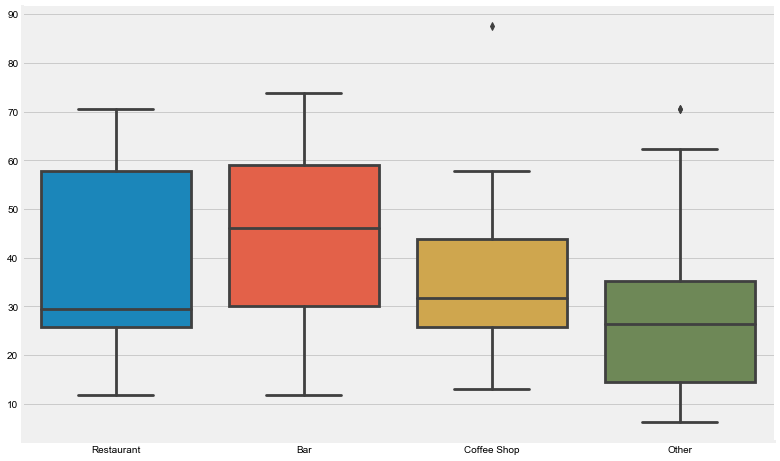

In [6]:
bldg_frontage_lengths = (
    frontages.groupby('building_id').geometry.apply(lambda srs: srs.length.sum()) * (360 / 0.001)
)

bldg_trash_per_unit_length = (
 trash
 .set_index('building_id')
 .join(buildings, how='left', lsuffix='_trash', rsuffix='_building')
 .reset_index()
 .groupby('building_id')
 .apply(lambda df: len(df) / bldg_frontage_lengths[df.name])
 .rename('trash_density')
 .to_frame()
 .assign(avg_yelp_stars=buildings['avg_yelp_stars'])
)

rows = []

for c in [c for c in buildings.columns if 'has_' in c]:
    _type = c[4:]
    for building_id, srs in buildings[c].iteritems():
        if buildings.loc[building_id, 'has_' + _type]:
            rows.append([building_id, _type])

bldg_business_types = (
    pd.DataFrame(rows, columns=['building_id', 'business_type'])
    .set_index('building_id')
    .assign(trash_rate=bldg_trash_per_unit_length.trash_density)
)

fig, ax = plt.subplots(1, figsize=(12, 8))
plt.style.use('seaborn-poster')
sns.set_style('white')

sns.boxplot(
    data=bldg_business_types.assign(
        business_type=bldg_business_types.business_type.map(
            lambda v: v if v in ['bar', 'coffee_shop', 'restaurant'] else 'other'
        )
    ).pipe(lambda df: df.assign(business_type=df.business_type.str.title().str.replace('_', ' '))),
    x='business_type', y='trash_rate', ax=ax,
    order=['Restaurant', 'Bar', 'Coffee Shop', 'Other']
)
ax.set_xlabel(None)
ax.set_ylabel(None)
sns.despine()

## Choropleth of block by trash volume

In [7]:
blocks.sort_index()

,statefp10,mtfcc10,uace10,name10,intptlat10,blockce10,awater10,funcstat10,aland10,tractce10,intptlon10,ur10,countyfp10,geometry
block_id,,,,,,,,,,,,,,
060750109002002,06,G5040,None,Block 2002,+37.7974669,2002,0,S,15248,010900,-122.4212319,None,075,"(POLYGON ((-122.420317 37.797109, -122.421961 ..."
060750109002003,06,G5040,None,Block 2003,+37.7965361,2003,0,S,15480,010900,-122.4210349,None,075,"(POLYGON ((-122.42011 37.796095, -122.420217 3..."
060750109003000,06,G5040,None,Block 3000,+37.7993320,3000,0,S,15368,010900,-122.4216084,None,075,"(POLYGON ((-122.420689 37.798971, -122.422337 ..."
060750109003001,06,G5040,None,Block 3001,+37.7991292,3001,0,S,14520,010900,-122.4232078,None,075,"(POLYGON ((-122.422337 37.798762, -122.423982 ..."
060750109003003,06,G5040,None,Block 3003,+37.7981949,3003,0,S,14572,010900,-122.4230188,None,075,"(POLYGON ((-122.422148 37.797825, -122.423793 ..."
060750109003004,06,G5040,None,Block 3004,+37.7983978,3004,0,S,15484,010900,-122.4214186,None,075,"(POLYGON ((-122.420501 37.798033, -122.422148 ..."
060750109003006,06,G5040,None,Block 3006,+37.7972641,3006,0,S,14409,010900,-122.4228310,None,075,"(POLYGON ((-122.423601 37.796691, -122.423521 ..."
060750109003008,06,G5040,None,Block 3008,+37.7963237,3008,0,S,14864,010900,-122.4226412,None,075,"(POLYGON ((-122.421768 37.795945, -122.423413 ..."


/Users/alex/miniconda3/envs/trash-talk-dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/alex/miniconda3/envs/trash-talk-dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/alex/miniconda3/envs/trash-talk-dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/alex/miniconda3/envs/trash-talk-dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/alex/

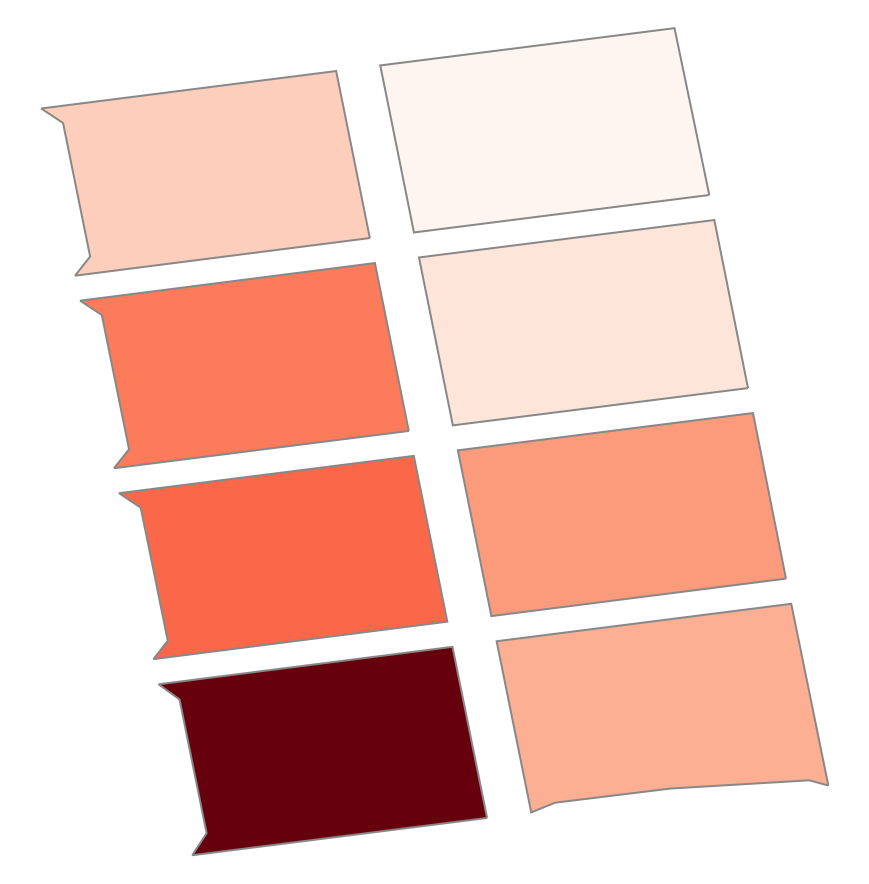

In [9]:
fig, ax = plt.subplots(1, figsize=(24, 16))
import matplotlib as mpl
# import mplleaflet

mpl.rcParams.update(mpl.rcParamsDefault)
sns.reset_orig()

gplt.choropleth(
    blocks.assign(
        trash_volume=(trash.block_id.value_counts().sort_index() / (trash.time.max() - trash.time.min()).days)
    ).pipe(
        lambda df: df.assign(geometry=df.geometry.scale(xfact=0.87, yfact=0.87))
    ),
    hue='trash_volume',
    cmap='Reds', k=None, linewidth=2, edgecolor='#888888',
    extent=blocks.geometry.scale(xfact=1.05, yfact=1.05).total_bounds,
    ax=ax
)

In [23]:
(trash.block_id.value_counts().sort_index() / (trash.time.max() - trash.time.min()).days)

060750109002002    41.575092
060750109002003    37.025641
060750109003000    15.684982
060750109003001    29.494505
060750109003003    48.769231
060750109003004    22.692308
060750109003006    53.124542
060750109003008    89.571429
Name: block_id, dtype: float64

I added text labels by hand in Inkscape.

## Generalized plot of trash

(0.5, -0.5)


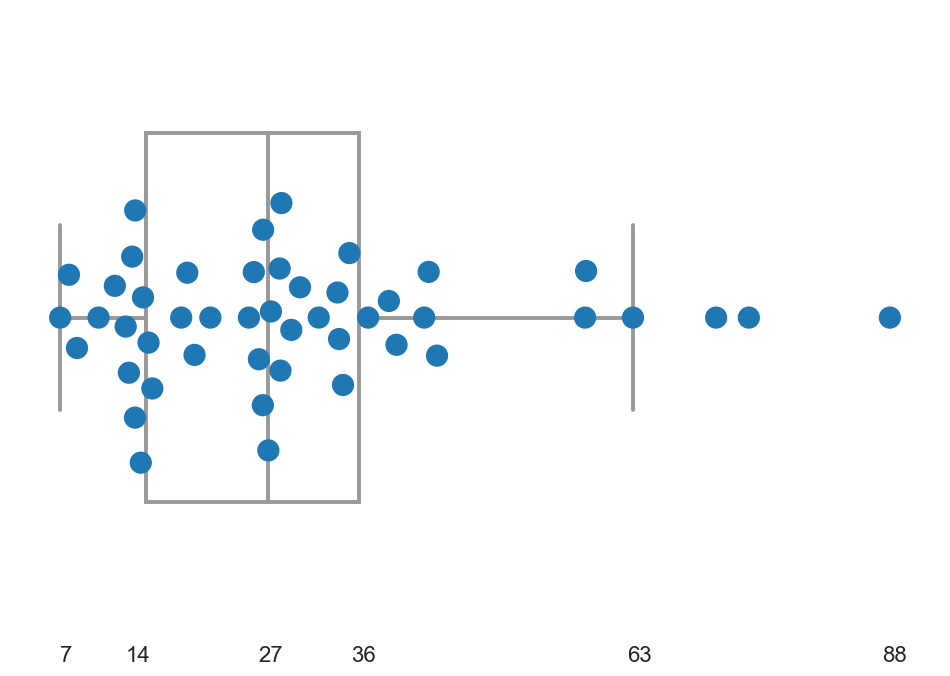

In [22]:
fig, ax = plt.subplots(1, figsize=(12, 8))
plt.style.use('seaborn-poster')
sns.set_style('white')

ax = sns.boxplot(
    data=bldg_trash_per_unit_length.trash_density, orient='h',
    color='white',
    width=0.3
)
sns.swarmplot(
    bldg_trash_per_unit_length.trash_density,
    # hue=pd.Series(
    #     bldg_trash_per_unit_length.index.map(lambda v: buildings.loc[v].block_id))\
    #     .astype('category').cat.codes,
    size=16, ax=ax
)
sns.despine(left=True, bottom=True)
plt.gca().set_xlabel(None)
plt.gca().set_xticks([7, 14, 27, 36, 63, 88])
print(plt.gca().get_ylim())
plt.gca().set_ylim([0.25, -0.25])
pass

## Investigate the Rubbish cig disposal unit

I can't think of anything that would not have already shown up in the plots I tried, if it was detectable.

In [11]:
# import spaghetti as spgh
# net = spgh.Network(in_data=frontages)
# net.snapobservations(trash, 'trash')
# updated_trash_points = spgh.element_as_gdf(net, pp_name='trash', snapped=True)

# 37.79709, -122.4221

## Scrap

Used in article writing.

In [12]:
len(gpd.read_file('../../data/processed/trash.json'))

131391